In [1]:
import sys
import subprocess
import os
from os import listdir
from os.path import isfile, join
import numpy as np

# Different training sizes

size1_corpus -> get 25% of text8 <br/>
size2_corpus -> get 50% of text8 <br/>
size3_corpus -> get 75% of text8 <br/>
size4_corpus -> get 100% of text8 <br/>

In [2]:
#read sampling
file_read  = open("text8", "r") 

In [3]:
num_lines = sum(1 for line in open('text8'))
num_lines

1

In [4]:
data = file_read.readline()
file_read.close()
data = data.split(" ")
len(data)

17005208

In [7]:
#get size corpus
size_corpus = []
sizes = [0.25, 0.5, 0.75, 1]
for i in range(0,4):
    size_corpus.append(round(len(data)*sizes[i]))

In [9]:
corpus = []
#get content corpus
for i in range(0,4):
    corpus.append(' '.join(data[0:size_corpus[i]]))

In [15]:
#writefile
for i in range(0,4):
    file_write = open("text8_size"+str(i+1), "w")
    file_write.write(corpus[i])
    file_write.close()

In [16]:
os.path.getsize("text8_size1")

24963753

In [17]:
os.path.getsize("text8_size2")

50103445

In [18]:
os.path.getsize("text8_size3")

75118081

os.path.getsize("text8_size4")

# Run Models

In [25]:
def run_model(command):
    p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    while True:
        out = p.stdout.read(100)
        if len(out) == 0 and p.poll() != None:
            break
        if out != '':
            sys.stdout.write("\r")
            sys.stdout.write(out)
            sys.stdout.flush()

In [25]:
file_corpus = ["text8_size1", "text8_size2", "text8_size3", "text8_size4"]

In [26]:
windows = [3, 4, 5, 6, 7]

In [27]:
cbow_skipgram = [1, 0]

In [29]:
number_of_models = len(file_corpus)*len(windows)*len(cbow_skipgram)
model = 1
for typ in cbow_skipgram:
    for file in file_corpus:
        for window in windows:
            print("MODELO " + str(i)+"/"+str(number_of_models))
            model_command = "./word2vec -train "+ str(file) +" -output model_"+str(model)+".bin -cbow "+ str(typ) + " -window "+ str(window)+" -binary 1"
            run_model(model_command)
            model = model + 1   

# Ajust Test File

In [30]:
#read sampling
file_read  = open("questions-words.txt", "r") 

In [31]:
data_test = file_read.readlines()
file_read.close()

In [32]:
file_write = open("file_test_questions_words.txt", "w")
for d in data_test:
    if(":" not in d):
        d = d.lower()
        file_write.write(d)
file_write.close()

# Run Word Analogy - Find distances

In [30]:
def read_file_test():
    file_read  = open("file_test_questions_words.txt", "r")
    data = file_read.readlines()
    file_read.close()
    return data

In [31]:
def sequence_words(words):
    seq_words = [str(words[0:3]).replace("'","").replace("[","").replace("]","").replace(",","").encode('utf-8')]
    seq_words.append("EXIT\n".encode('utf-8'))
    
    return seq_words

In [32]:
def run_word_analogy(command, seq_words):
    p = subprocess.Popen(command, stdout=subprocess.PIPE, stdin=subprocess.PIPE, shell=True)
    result = p.communicate(b'\n'.join(seq_words))
    result = (str(result[0]).split(";"))
    if(len(result) > 5):
        #delete invalid data
        del result[0] 
        del result[-1]
        del result[-1]
    return result

In [33]:
def get_info_first_word(result):
    word, dist = result[0].split(":")
    word = word.lstrip()
    dist = float(dist)
    return word, dist

In [34]:
def get_distance(result):
    distance = 0
    find_word = False
    if(len(result) > 5): #returned ranking
        first_word, dist_first_word = get_info_first_word(result)
        for r in result:
            w, d = r.split(":")
            if(words[3] == w.lstrip()):
                distance = dist_first_word - float(d)
                find_word = True
                break   
    else: #not ranking
        find_word = True
        distance = -1
    if(not find_word):
        distance = -2
    return distance

In [35]:
# write file distances
#writefile
def write_file(id_modelo, distance):
    file_write = open("result_modelo_"+id_modelo, "a")
    file_write.write(str(distance))
    file_write.write("\n")
    file_write.close() 
    #print("Write Model " + str(id_modelo))

In [36]:
mypath = "./models/"

models = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [37]:
mypath2 = "./results/"

results_models = [f for f in listdir(mypath2) if isfile(join(mypath2, f))]

In [38]:
idModels_runneds = []
for res in results_models:
    idModels_runneds.append(res[14:])

In [39]:
#  0 -> palavra do topo
# -1 -> não tem ranking
# -2 -> não ta no ranking

In [41]:
#for m in models:
for m in models:
    idModel = m[6:].replace(".bin","")
    command = './word-analogy ./models/' + m
    
    #if(idModel in idModels_runneds):
    #    continue
    
    data_test = read_file_test()
    i = 1
    size = len(data_test)
    for d in data_test:
        print("MODELO "+idModel + " " +str(i)+"/"+str(size))
        words = d.replace("\n","")
        words = words.split(" ")
        seq_words = sequence_words(words)
        result = run_word_analogy(command,seq_words)
        distance = get_distance(result)
        write_file(idModel, distance)
        i = i + 1
    idModels_runneds.append(idModel)

# Evalute Models

In [42]:
import matplotlib.pyplot as plt

import matplotlib
%matplotlib inline 

In [43]:
mypath = "./results/"

models = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [44]:
def get_results(models):
    result_models = {}
    for m in models:
        idModel = int(m[14:])
        file_read  = open("./results/"+m, "r") 
        data = file_read.readlines()
        distances = []
        for d in data:
            distances.append(float(d))
        result_models[idModel] = distances

    return result_models

In [45]:
def get_results_metrics(result_models):
    result_models_metrics = {} # mean, mean_wihout_0, ,dp, count_0, count_neg_1, count_neg_2

    for r in result_models:
        elements = []
        elements_not_zero = []
        count = 0
        count_0 = 0
        count_neg_1 = 0
        count_neg_2 = 0
        for d in result_models[r]:
            if(d == 0):
                count_0 = count_0 + 1
            if(d > 0):
                elements_not_zero.append(d)
            if(d >= 0):
                elements.append(d)
            elif(d == -1):
                count_neg_1 = count_neg_1 + 1
            elif(d == -2):
                count_neg_2 = count_neg_2 + 1
        result_models_metrics[r] = [round(np.mean(elements),6),round(np.mean(elements_not_zero),6),round(np.std(elements),6),count_0, count_neg_1, count_neg_2 ]
    return result_models_metrics


In [46]:
result_models = get_results(models)
result_models_metrics = get_results_metrics(result_models)

In [47]:
windows = [3,4,5,6,7]
sizes = [25, 50,75, 100]

## Gráficos

In [48]:
dist_percent_cbow = {}
qtde_0_percent_cbow = {}
qtde_neg_1_percent_cbow = {}
qtde_neg_2_percent_cbow = {}
j = 1
for i in range(1,21):
    if(i == 6 or i == 11 or i == 16 or i == 21):
        j = j + 1
    if j not in dist_percent_cbow.keys():
        dist_percent_cbow[j] = []
        qtde_0_percent_cbow[j] = []
        qtde_neg_1_percent_cbow[j] = []
        qtde_neg_2_percent_cbow[j] = []
    dist_percent_cbow[j].append(result_models_metrics[i][0])
    qtde_0_percent_cbow[j].append(result_models_metrics[i][3])
    qtde_neg_1_percent_cbow[j].append(result_models_metrics[i][4])
    qtde_neg_2_percent_cbow[j].append(result_models_metrics[i][5])

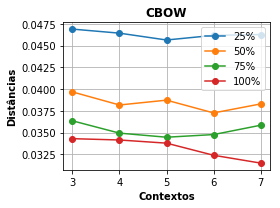

In [49]:
f, ax = plt.subplots(1,1,figsize=(4,3))

plt.plot(windows, dist_percent_cbow[1], marker='o', label="25%")
plt.plot(windows, dist_percent_cbow[2], marker='o', label="50%")
plt.plot(windows, dist_percent_cbow[3], marker='o', label="75%")
plt.plot(windows, dist_percent_cbow[4], marker='o', label="100%")

ax.set_xlabel('Contextos', fontweight='bold')
ax.set_ylabel('Distâncias', fontweight='bold')
ax.set_title("CBOW", fontweight='bold')
ax.legend(loc=1)
plt.grid(True)
f.tight_layout()
#plt.savefig('contexto_distancia_cbow.pdf', format='pdf', dpi=400)

In [50]:
dist_percent_skipgram = {}
qtde_0_percent_skipgram = {}
qtde_neg_1_percent_skipgram = {}
qtde_neg_2_percent_skipgram = {}
j = 0
for i in range(21,41):
    if(i == 21 or i == 26 or i == 31 or i == 36):
        j = j + 1
    if j not in dist_percent_skipgram.keys():
        dist_percent_skipgram[j] = []
        qtde_0_percent_skipgram[j] = []
        qtde_neg_1_percent_skipgram[j] = []
        qtde_neg_2_percent_skipgram[j] = []
    dist_percent_skipgram[j].append(result_models_metrics[i][0])
    qtde_0_percent_skipgram[j].append(result_models_metrics[i][3])
    qtde_neg_1_percent_skipgram[j].append(result_models_metrics[i][4])
    qtde_neg_2_percent_skipgram[j].append(result_models_metrics[i][5])

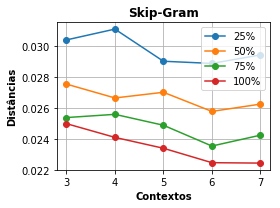

In [51]:
f, ax = plt.subplots(1,1,figsize=(4,3))

plt.plot(windows, dist_percent_skipgram[1], marker='o', label="25%")
plt.plot(windows, dist_percent_skipgram[2], marker='o', label="50%")
plt.plot(windows, dist_percent_skipgram[3], marker='o', label="75%")
plt.plot(windows, dist_percent_skipgram[4], marker='o', label="100%")


ax.set_xticks(windows)
ax.set_xlabel('Contextos', fontweight='bold')
ax.set_ylabel('Distâncias', fontweight='bold')
ax.set_title("Skip-Gram", fontweight='bold')
ax.legend(loc=1)

plt.grid(True)
f.tight_layout()
plt.savefig('contexto_distancia_skipgram.pdf', format='pdf', dpi=400)

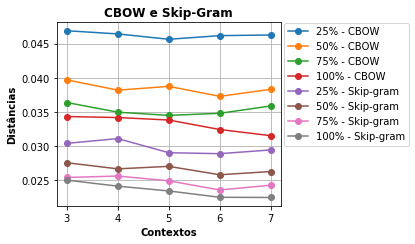

In [52]:
f, ax = plt.subplots(1,1,figsize=(6.5,3.5))

plt.plot(windows, dist_percent_cbow[1], marker='o', label="25% - CBOW")
plt.plot(windows, dist_percent_cbow[2], marker='o', label="50% - CBOW")
plt.plot(windows, dist_percent_cbow[3], marker='o', label="75% - CBOW")
plt.plot(windows, dist_percent_cbow[4], marker='o', label="100% - CBOW")

plt.plot(windows, dist_percent_skipgram[1], marker='o', label="25% - Skip-gram")
plt.plot(windows, dist_percent_skipgram[2], marker='o', label="50% - Skip-gram")
plt.plot(windows, dist_percent_skipgram[3], marker='o', label="75% - Skip-gram")
plt.plot(windows, dist_percent_skipgram[4], marker='o', label="100% - Skip-gram")

ax.set_xticks(windows)
ax.set_xlabel('Contextos', fontweight='bold')
ax.set_ylabel('Distâncias', fontweight='bold')
ax.set_title("CBOW e Skip-Gram", fontweight='bold')


plt.legend(loc='best',bbox_to_anchor=(.99, 0.526, 0.5, 0.5))
plt.xticks(windows)

plt.grid(True)
f.tight_layout()

plt.savefig('contexto_distancia_cbow_skipgram.pdf', format='pdf', dpi=400)

In [53]:
count_zeros_same_window_skipgram = {}
count_zeros_same_window_cbow = {}
for i in range(0,5):
    count_zeros_same_window_cbow[i] = [qtde_0_percent_cbow[1][i], qtde_0_percent_cbow[2][i], qtde_0_percent_cbow[3][i], qtde_0_percent_cbow[4][i]]
    count_zeros_same_window_skipgram[i] = [qtde_0_percent_skipgram[1][i], qtde_0_percent_skipgram[2][i], qtde_0_percent_skipgram[3][i], qtde_0_percent_skipgram[4][i]]

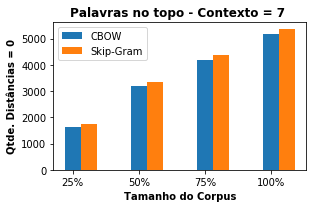

In [54]:
sizes2 = [19, 44, 69, 94]
f, ax = plt.subplots(1,1,figsize=(4.5,3))

p1 = ax.bar(sizes2, count_zeros_same_window_cbow[4], 6, label="CBOW")

p2 = ax.bar(sizes, count_zeros_same_window_skipgram[4], 6, label="Skip-Gram")

ax.set_xticklabels(('25%', '50%', '75%', '100%'))
ax.set_xticks(sizes2)
ax.set_xlabel("Tamanho do Corpus", fontweight='bold')
ax.set_ylabel("Qtde. Distâncias = 0", fontweight='bold')
ax.set_title("Palavras no topo - Contexto = 7 ", fontweight='bold')

ax.legend()
f.tight_layout()
#plt.savefig('palavras_topo.pdf', format='pdf', dpi=400)

In [55]:
qtde_neg_1_percent_cbow

{1: [5746, 5746, 5746, 5746, 5746],
 2: [3688, 3688, 3688, 3688, 3688],
 3: [2739, 2739, 2739, 2739, 2739],
 4: [1440, 1440, 1440, 1440, 1440]}

In [56]:
qtde_neg_1_percent_skipgram

{1: [5746, 5746, 5746, 5746, 5746],
 2: [3688, 3688, 3688, 3688, 3688],
 3: [2739, 2739, 2739, 2739, 2739],
 4: [1440, 1440, 1440, 1440, 1440]}

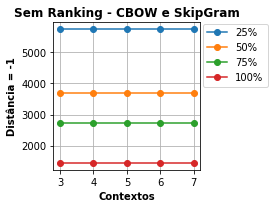

In [57]:
f, ax = plt.subplots(1,1,figsize=(4.7,3))

plt.plot(windows, qtde_neg_1_percent_cbow[1], marker='o', label="25%")
plt.plot(windows, qtde_neg_1_percent_cbow[2], marker='o', label="50%")
plt.plot(windows, qtde_neg_1_percent_cbow[3], marker='o', label="75%")
plt.plot(windows, qtde_neg_1_percent_cbow[4], marker='o', label="100%")
plt.xticks(windows)


ax.set_xlabel('Contextos', fontweight='bold')
ax.set_ylabel('Distância = -1', fontweight='bold')
ax.set_title("Sem Ranking - CBOW e SkipGram", fontweight='bold')

plt.legend(loc='best',bbox_to_anchor=(.99, 0.526, 0.5, 0.5))

plt.grid(True)
f.tight_layout()

plt.savefig('distancia_menos_1.pdf', format='pdf', dpi=400)

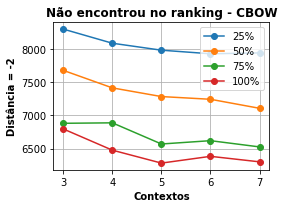

In [58]:
f, ax = plt.subplots(1,1,figsize=(4,3))

plt.plot(windows, qtde_neg_2_percent_cbow[1], marker='o', label="25%")
plt.plot(windows, qtde_neg_2_percent_cbow[2], marker='o', label="50%")
plt.plot(windows, qtde_neg_2_percent_cbow[3], marker='o', label="75%")
plt.plot(windows, qtde_neg_2_percent_cbow[4], marker='o', label="100%")

ax.set_xticks(windows)
ax.set_xlabel('Contextos', fontweight='bold')
ax.set_ylabel('Distância = -2', fontweight='bold')
ax.set_title("Não encontrou no ranking - CBOW", fontweight='bold')

plt.grid(True)
plt.legend(loc=1)
f.tight_layout()

plt.savefig('distancia_menos_2_cbow.pdf', format='pdf', dpi=400)

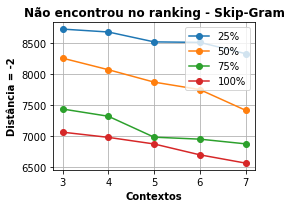

In [59]:
f, ax = plt.subplots(1,1,figsize=(4,3))

plt.plot(windows, qtde_neg_2_percent_skipgram[1], marker='o', label="25%")
plt.plot(windows, qtde_neg_2_percent_skipgram[2], marker='o', label="50%")
plt.plot(windows, qtde_neg_2_percent_skipgram[3], marker='o', label="75%")
plt.plot(windows, qtde_neg_2_percent_skipgram[4], marker='o', label="100%")

ax.set_xticks(windows)
ax.set_xlabel('Contextos', fontweight='bold')
ax.set_ylabel('Distância = -2', fontweight='bold')
ax.set_title("Não encontrou no ranking - Skip-Gram", fontweight='bold')

plt.grid(True)
plt.legend(loc=1)
f.tight_layout()

plt.savefig('distancia_menos_2_skipgram.pdf', format='pdf', dpi=400)

## Tabela

In [60]:
file_write = open("table_metrics.csv", "w")
for i in range(1,41):
    file_write.write(str(i)+","+str(result_models_metrics[i]).replace("[","").replace("]","")+"\n")
file_write.close()